<a href="https://colab.research.google.com/github/amadousysada/content-recommendation/blob/main/analyse-exploratoire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import time
init_time = time.time()

import os
import scipy
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import sklearn
print("Versions:")
print(f"{' '*2}- Numpy        =>: {np.__version__}")
print(f"{' '*2}- Pandas   =>: {pd.__version__}")
print(f"{' '*2}- sklearn   =>: {sklearn.__version__}")

Versions:
  - Numpy        =>: 2.0.2
  - Pandas   =>: 2.2.2
  - sklearn   =>: 1.6.1


In [3]:
base_path = "/content/drive/MyDrive/data/p10_content_recommendation"

ARTICLE_EMBEDDINGS_FILE = os.path.join(base_path, "articles_embeddings.pickle")
ARTICLE_METADATA_FILE = os.path.join(base_path, "articles_metadata.csv")
CLICKS_SAMPLES_FILE = os.path.join(base_path, "clicks_sample.csv")
CLICKS_FOLDER_PATH = os.path.join(base_path, "clicks")

In [4]:
print("ARTICLE_EMBEDDINGS_FILE: "+ str(ARTICLE_EMBEDDINGS_FILE))
print("ARTICLE_METADATA_FILE: "+ str(ARTICLE_METADATA_FILE))
print("CLICKS_FOLDER_PATH: "+ str(CLICKS_FOLDER_PATH))

ARTICLE_EMBEDDINGS_FILE: /content/drive/MyDrive/data/p10_content_recommendation/articles_embeddings.pickle
ARTICLE_METADATA_FILE: /content/drive/MyDrive/data/p10_content_recommendation/articles_metadata.csv
CLICKS_FOLDER_PATH: /content/drive/MyDrive/data/p10_content_recommendation/clicks


In [5]:
embeddings = pd.read_pickle(ARTICLE_EMBEDDINGS_FILE)
embeddings.shape

(364047, 250)

In [6]:
articles_metadata = pd.read_csv(ARTICLE_METADATA_FILE)

In [7]:
articles_metadata.head(10)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
5,5,1,1407413929000,0,196
6,6,1,1409896802000,0,203
7,7,1,1412559620000,0,154
8,8,1,1414351550000,0,209
9,9,1,1412526792000,0,181


In [8]:
articles_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


In [9]:
print(f"Nombre total de category: {len(articles_metadata.category_id.unique())}")

Nombre total de category: 461


In [10]:
clicks_sample = pd.read_csv(CLICKS_SAMPLES_FILE)

In [11]:
clicks_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   user_id              1883 non-null   int64
 1   session_id           1883 non-null   int64
 2   session_start        1883 non-null   int64
 3   session_size         1883 non-null   int64
 4   click_article_id     1883 non-null   int64
 5   click_timestamp      1883 non-null   int64
 6   click_environment    1883 non-null   int64
 7   click_deviceGroup    1883 non-null   int64
 8   click_os             1883 non-null   int64
 9   click_country        1883 non-null   int64
 10  click_region         1883 non-null   int64
 11  click_referrer_type  1883 non-null   int64
dtypes: int64(12)
memory usage: 176.7 KB


In [12]:
clicks_sample.head(10)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
5,2,1506825435299739,1506825435000,2,30970,1506827120575,4,1,17,1,24,2
6,3,1506825442704740,1506825442000,2,236065,1506827536942,4,3,2,1,21,1
7,3,1506825442704740,1506825442000,2,236294,1506827566942,4,3,2,1,21,1
8,4,1506825528135741,1506825528000,2,48915,1506826927593,4,1,17,1,17,1
9,4,1506825528135741,1506825528000,2,44488,1506826957593,4,1,17,1,17,1


In [182]:
clicks_sample.rename(columns={'click_article_id': 'article_id'}, inplace=True)

# Modelisation

In [275]:
clicks_train_df, clicks_test_df = train_test_split(clicks_sample, test_size=0.2, random_state=42)

In [298]:
import random

EVAL_RANDOM_SAMPLE_NON_CLICKED_ARTICLES = 100

def get_articles_clicked(user_id, clicked_df):
    clicked_articles = clicked_df.loc[clicked_df.user_id==user_id, 'article_id'].unique().tolist()
    return clicked_articles

def get_not_clicked_articles_sample(user_id, sample_size, articles_to_ignore, seed=42):
        all_articles = articles_metadata.article_id.unique().tolist()
        non_clicked_articles = set(all_articles) - set(articles_to_ignore)
        random.seed(seed)
        non_clicked_articles_sample = random.sample(list(non_clicked_articles), sample_size)
        return set(non_clicked_articles_sample)

def verify_hit_top_n(article_id, recommended_articles, topn):
            try:
                index = next(i for i, c in enumerate(recommended_articles) if c == article_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

def evaluate_model_for_user(model, user_id):
        #Getting the articles in test set
        clicked_values_testset = clicks_test_df.loc[clicks_test_df.user_id==user_id, 'article_id'].unique().tolist()
        clicked_articles_count_testset = len(clicked_values_testset)

        #Getting a ranked recommendation list from a model for a given user
        user_recs_df = model.recommend_items(user_id, items_to_ignore=get_articles_clicked(user_id=user_id, clicked_df=clicks_train_df), topn=100)
        hits_at_5_count = 0
        hits_at_10_count = 0
        recall_at_5 = 0
        recall_at_10 = 0
        #For each item the user has clicked in test set
        for article_id in clicked_values_testset:
            #Getting a random sample (100) articles the user has not clicked
            #(to represent articles that are assumed to be no relevant to the user)
            non_clicked_articles_sample = get_not_clicked_articles_sample(user_id,
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_CLICKED_ARTICLES,
                                                                          articles_to_ignore=get_articles_clicked(user_id, clicks_train_df),
                                                                          seed=article_id%(2**32))

            #Combining the current clicked item with the 100 random articles
            articles_to_filter_recs = non_clicked_articles_sample.union(set([article_id]))

            #Filtering only recommendations that are either the clicked item or from a random sample of 100 non-clicked articles
            valid_recs_df = user_recs_df[user_recs_df['article_id'].isin(articles_to_filter_recs)]
            valid_recs = valid_recs_df['article_id'].values
            #Verifying if the current clicked item is among the Top-N recommended articles
            hit_at_5, index_at_5 = verify_hit_top_n(article_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = verify_hit_top_n(article_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the clicked articles that are ranked among the Top-N recommended articles,
        #when mixed with a set of non-relevant articles
        if clicked_articles_count_testset > 0:
          recall_at_5 = hits_at_5_count / float(clicked_articles_count_testset)
          recall_at_10 = hits_at_10_count / float(clicked_articles_count_testset)

        user_metrics = {'hits@5_count':hits_at_5_count,
                          'hits@10_count':hits_at_10_count,
                          'clicked_count': clicked_articles_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return user_metrics

def evaluate_model(model):
        #print('Running evaluation for users')
        people_metrics = []
        for _, user_id in enumerate(clicks_test_df.user_id.unique().tolist()):
            user_metrics = evaluate_model_for_user(model, user_id)
            user_metrics['_user_id'] = user_id
            people_metrics.append(user_metrics)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('clicked_count', ascending=False)

        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['clicked_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['clicked_count'].sum())

        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}
        return global_metrics, detailed_results_df

In [278]:
already_seen = get_articles_clicked(user_id=681, clicked_df=clicks_sample)

## Popularity model

In [67]:
item_popularity_df = clicks_sample\
                      .groupby('article_id')\
                      .agg(
                          clicks=('user_id','size'),
                          unique_users=('user_id','nunique')
                      )\
                      .reset_index()\
                      .rename(columns={'article_id': 'article_id'})

item_popularity_df['depth'] = item_popularity_df['clicks'] / item_popularity_df['unique_users'].clip(lower=1)  # >1 si des users cliquent plusieurs fois

for col in ['clicks', 'unique_users', 'depth']:
    item_popularity_df[f'{col}_log'] = np.log1p(item_popularity_df[col])
    item_popularity_df[f'{col}_pct'] = item_popularity_df[f'{col}_log'].rank(pct=True)

# pondérations
w_clicks, w_users, w_depth = 0.3, 0.5, 0.2
item_popularity_df['score'] = (w_users*item_popularity_df['unique_users_pct']
                    + w_clicks*item_popularity_df['clicks_pct']
                    + w_depth*item_popularity_df['depth_pct'])

item_popularity_df_sorted = item_popularity_df.sort_values('score', ascending=False)
item_popularity_df_sorted.head(10)

,article_id,clicks,unique_users,depth,clicks_log,clicks_pct,unique_users_log,unique_users_pct,depth_log,depth_pct,score
95,119592,202,202,1.0,5.313206,1.000000,5.313206,1.000000,0.693147,0.501548,0.900310
73,96663,153,153,1.0,5.036953,0.996904,5.036953,0.996904,0.693147,0.501548,0.897833
84,108854,126,126,1.0,4.844187,0.992260,4.844187,0.992260,0.693147,0.501548,0.894118
257,284847,126,126,1.0,4.844187,0.992260,4.844187,0.992260,0.693147,0.501548,0.894118
209,235840,106,106,1.0,4.672829,0.987616,4.672829,0.987616,0.693147,0.501548,0.890402
117,145166,83,83,1.0,4.430817,0.984520,4.430817,0.984520,0.693147,0.501548,0.887926
48,68866,78,78,1.0,4.369448,0.981424,4.369448,0.981424,0.693147,0.501548,0.885449
270,288431,71,71,1.0,4.276666,0.978328,4.276666,0.978328,0.693147,0.501548,0.882972
176,207122,49,49,1.0,3.912023,0.975232,3.912023,0.975232,0.693147,0.501548,0.880495
154,168868,47,47,1.0,3.871201,0.972136,3.871201,0.972136,0.693147,0.501548,0.878019


In [68]:
class PopularityRecommender:

    MODEL_NAME = 'Popularity'

    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['article_id'].isin(items_to_ignore)] \
                               .sort_values('score', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'article_id',
                                                          right_on = 'article_id')[['article_id', 'score','category_id', 'words_count']]

        return recommendations_df

In [279]:
popularity_model = PopularityRecommender(item_popularity_df_sorted, articles_metadata)
popularity_model.recommend_items(user_id=50, items_to_ignore=already_seen, topn=10, verbose=True)

,article_id,score,category_id,created_at_ts,publisher_id,words_count
0,119592,0.900310,247,1506784316000,0,239
1,96663,0.897833,209,1506788025000,0,206
2,108854,0.894118,230,1506805783000,0,167
3,235840,0.890402,375,1506807839000,0,159
4,145166,0.887926,269,1506785272000,0,180
5,207122,0.880495,331,1506799106000,0,1044
6,168868,0.878019,297,1506796851000,0,147
7,157541,0.875542,281,1506800518000,0,280
8,202436,0.873065,327,1506788143000,0,333
9,159359,0.870588,281,1506757416000,0,139


> Evaluation

In [299]:
%%time
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...

Global metrics:
{'modelName': 'Popularity', 'recall@5': np.float64(0.8594164456233422), 'recall@10': np.float64(0.8594164456233422)}
CPU times: user 15.1 s, sys: 8.87 s, total: 23.9 s
Wall time: 23.9 s


,hits@5_count,hits@10_count,clicked_count,recall@5,recall@10,_user_id
9,8,8,10,0.8,0.8,681
54,4,4,4,1.0,1.0,183
160,2,2,4,0.5,0.5,64
67,3,3,3,1.0,1.0,115
44,3,3,3,1.0,1.0,599
123,3,3,3,1.0,1.0,607
100,3,3,3,1.0,1.0,134
12,1,1,2,0.5,0.5,627
264,2,2,2,1.0,1.0,496
276,2,2,2,1.0,1.0,409


## Content-Based Filtering model

In [301]:
def get_article_profile(article_id):
    article_profile = embeddings[article_id]
    return article_profile

def get_article_profiles(ids):
    article_profiles_list = [get_article_profile(x) for x in ids]
    # Convert each NumPy array to a sparse matrix before stacking
    #sparse_article_profiles_list = [scipy.sparse.csr_matrix(arr) for arr in article_profiles_list]
    article_profiles = np.vstack(article_profiles_list)
    return article_profiles

def build_users_profile(person_id, interactions_indexed_df):
    clicks_person_df = clicks_sample.loc[clicks_sample.user_id==person_id]
    user_article_profiles = get_article_profiles(clicks_person_df['article_id'])

    #user_article_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of article profiles by the interactions strength
    #user_article_strengths_weighted_avg = np.sum(user_article_profiles.multiply(user_article_strengths), axis=0) / np.sum(user_article_strengths)
    #user_profile_norm = sklearn.preprocessing.normalize(user_article_strengths_weighted_avg)
    #return user_profile_norm
    w = np.ones((user_article_profiles.shape[0], 1), dtype=float) / user_article_profiles.shape[0]
    user_article_profiles = (user_article_profiles * w).sum(axis=0, keepdims=True)

    # normalisation L2 (utile pour cosine)
    user_article_profiles = user_article_profiles / (np.linalg.norm(user_article_profiles) + 1e-12)
    return user_article_profiles

def build_users_profiles():
    user_profiles = {}
    for person_id in clicks_sample.user_id.unique():
        user_profiles[person_id] = build_users_profile(person_id, clicks_sample)
    return user_profiles

In [302]:
user_profiles = build_users_profiles()

In [303]:
len(user_profiles)

707

In [304]:
myprofile = user_profiles[50]
myprofile.shape

(1, 250)

In [305]:
pd.DataFrame(user_profiles[50].flatten().tolist(), columns=['vector'])

,vector
0,-0.101656
1,-0.167328
2,-0.082715
3,-0.054706
4,-0.042612
...,...
245,0.099549
246,-0.087196
247,-0.025725
248,0.025121


In [306]:
class ContentBasedRecommender:

    MODEL_NAME = 'Content-Based'

    def __init__(self, items_df=None):
        self.item_ids = articles_metadata.article_id.unique()
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], embeddings)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(self.item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))

        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['article_id', 'score']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'article_id',
                                                          right_on = 'article_id')[['article_id', 'score','category_id', 'words_count']]

        return recommendations_df

In [307]:
content_based_recommender_model = ContentBasedRecommender(articles_metadata)
content_based_recommender_model.recommend_items(user_id=50, items_to_ignore=already_seen, topn=10, verbose=True)

,article_id,score,category_id,words_count
0,94422,0.808407,209,181
1,89932,0.785339,199,159
2,90272,0.779438,199,177
3,94255,0.777987,209,151
4,95216,0.777330,209,156
5,96663,0.775055,209,206
6,90735,0.774066,199,159
7,91087,0.773101,199,158
8,90275,0.772017,199,165
9,89871,0.768874,199,225


> Evaluation

In [309]:
%%time
print('Evaluation du model Content Based Filtering model...')
cbf_global_metrics, cbf_detailed_results_df = evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cbf_global_metrics)
cbf_detailed_results_df.head(10)

Evaluation du model Content Based Filtering model...

Global metrics:
{'modelName': 'Content-Based', 'recall@5': np.float64(0.5490716180371353), 'recall@10': np.float64(0.5490716180371353)}
CPU times: user 47min 21s, sys: 1min 33s, total: 48min 54s
Wall time: 4min 37s


,hits@5_count,hits@10_count,clicked_count,recall@5,recall@10,_user_id
9,1,1,10,0.100000,0.100000,681
54,0,0,4,0.000000,0.000000,183
160,0,0,4,0.000000,0.000000,64
67,2,2,3,0.666667,0.666667,115
44,0,0,3,0.000000,0.000000,599
123,0,0,3,0.000000,0.000000,607
100,2,2,3,0.666667,0.666667,134
12,1,1,2,0.500000,0.500000,627
264,1,1,2,0.500000,0.500000,496
276,0,0,2,0.000000,0.000000,409


## Collaborative Filtering model

In [98]:
#Creating a sparse pivot table with users in rows and items in columns
users_articles_pivot_matrix_df = clicks_sample.drop_duplicates(["user_id","article_id"])\
                                  .assign(val=1)\
                                  .pivot(index='user_id', columns='article_id', values='val')\
                                  .fillna(0)
users_articles_pivot_matrix_df.head(10)

click_article_id,2137,2662,4243,4658,7947,8844,10955,13337,13540,14197,...,352774,352809,353669,355863,361700,361714,361969,362816,363033,363291
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
users_articles_pivot_matrix = users_articles_pivot_matrix_df.to_numpy()
users_articles_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [108]:
ids  = users_articles_pivot_matrix_df.index.to_numpy()
ids[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [110]:
from scipy.sparse import csr_matrix

users_articles_pivot_sparse_matrix = csr_matrix(users_articles_pivot_matrix)
users_articles_pivot_sparse_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1883 stored elements and shape (707, 323)>

In [114]:
from scipy.sparse.linalg import svds
NUMBER_OF_FACTORS_MF = 15
U, sigma, Vt = svds(users_articles_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(707, 15)
(15,)
(15, 323)


In [115]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [118]:
all_user_predicted_clicks = np.dot(np.dot(U, sigma), Vt)
all_user_predicted_clicks

array([[-3.56604422e-03, -1.92827139e-05,  5.98578529e-03, ...,
        -1.73259433e-03, -1.59545027e-04, -1.12198719e-02],
       [-3.16280655e-04,  1.19489681e-04,  8.89324469e-03, ...,
        -1.73421696e-03, -2.37826668e-03, -1.75073243e-02],
       [ 3.22667607e-03, -8.19107435e-06,  9.70260253e-03, ...,
         9.17694050e-03,  3.87921112e-03,  1.06068183e-01],
       ...,
       [ 8.00845320e-03, -3.64269862e-05, -4.90167980e-04, ...,
         6.77366970e-03, -2.78510596e-04,  1.89741226e-01],
       [-2.18964929e-03,  5.40039856e-07,  7.68572760e-04, ...,
         4.49414519e-03,  3.76768002e-03,  3.29593091e-02],
       [-1.23002429e-03, -2.94064798e-05,  6.09417677e-03, ...,
        -2.21993632e-03, -2.20963472e-03,  7.92601757e-03]])

In [123]:
all_user_predicted_clicks_norm = (all_user_predicted_clicks - all_user_predicted_clicks.min()) / (all_user_predicted_clicks.max() - all_user_predicted_clicks.min())
cf_preds_df = pd.DataFrame(all_user_predicted_clicks_norm, columns = users_articles_pivot_matrix_df.columns, index=ids).transpose()
cf_preds_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,697,698,699,700,701,702,703,704,705,706
click_article_id,,,,,,,,,,,,,,,,,,,,,
2137,0.149923,0.151878,0.154009,0.152228,0.152140,0.147792,0.150763,0.151459,0.152295,0.152380,...,0.152083,0.151123,0.151162,0.150982,0.170472,0.151459,0.152068,0.156885,0.150751,0.151328
2662,0.152056,0.152140,0.152063,0.152072,0.152068,0.152090,0.152022,0.152147,0.152068,0.152064,...,0.152116,0.152036,0.152068,0.152124,0.152059,0.152147,0.152068,0.152046,0.152068,0.152050
4243,0.155668,0.157417,0.157904,0.154091,0.152386,0.164441,0.148384,0.156949,0.151138,0.152071,...,0.152893,0.146252,0.152540,0.156002,0.154696,0.156949,0.152068,0.151773,0.152530,0.155734
4658,0.150610,0.151316,0.155944,0.152975,0.152359,0.162918,0.151181,0.151099,0.151510,0.151700,...,0.149805,0.150540,0.154600,0.151219,0.149288,0.151099,0.152068,0.150540,0.154774,0.149824
7947,0.164835,0.154444,0.156403,0.152744,0.152545,0.160488,0.155732,0.155285,0.151127,0.151122,...,0.156574,0.151237,0.155662,0.153632,0.157585,0.155285,0.152068,0.167561,0.155432,0.148769
8844,0.152056,0.152140,0.152063,0.152072,0.152068,0.152090,0.152022,0.152147,0.152068,0.152064,...,0.152116,0.152036,0.152068,0.152124,0.152059,0.152147,0.152068,0.152046,0.152068,0.152050
10955,0.152068,0.152068,0.152068,0.152068,0.152068,0.152068,0.152066,0.152068,0.152068,0.152068,...,0.152068,0.152068,0.152068,0.152068,0.152067,0.152068,0.152068,0.152067,0.152068,0.152068
13337,0.151522,0.156420,0.151548,0.152080,0.152048,0.152579,0.150865,0.151189,0.151473,0.152046,...,0.149850,0.151070,0.150869,0.151163,0.150906,0.151189,0.152068,0.152352,0.150907,0.155721
13540,0.151081,0.155351,0.155024,0.152123,0.152042,0.152090,0.149913,0.150088,0.150793,0.151903,...,0.148257,0.150280,0.153856,0.150293,0.150249,0.150088,0.152068,0.151562,0.153911,0.154609


In [124]:
len(cf_preds_df.columns)

707

In [147]:
class CFRecommender:

    MODEL_NAME = 'Collaborative Filtering'

    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'score'})
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['article_id'].isin(items_to_ignore)] \
                               .sort_values('score', ascending = False) \
                               .head(topn)
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'article_id',
                                                          right_on = 'article_id')[['article_id', 'score','category_id', 'words_count']]
        return recommendations_df

In [148]:
cf_recommender_model = CFRecommender(cf_preds_df, articles_metadata)
cf_recommender_model.recommend_items(user_id=50, items_to_ignore=already_seen, topn=10, verbose=True)

,article_id,score,category_id,words_count
0,285412,0.169850,412,199
1,284845,0.169347,412,235
2,168701,0.167153,297,222
3,182456,0.165137,301,160
4,263974,0.162222,398,274
5,270225,0.161843,399,194
6,162286,0.161746,281,293
7,141517,0.160898,265,106
8,277681,0.160445,410,191
9,352227,0.160272,442,151


> Evaluation

In [300]:
%%time
print('Evaluation du model Collaborative Filtering model...')
cf_global_metrics, cf_detailed_results_df = evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluation du model Collaborative Filtering model...

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': np.float64(0.9628647214854111), 'recall@10': np.float64(0.9628647214854111)}
CPU times: user 15.5 s, sys: 9.08 s, total: 24.5 s
Wall time: 24.5 s


,hits@5_count,hits@10_count,clicked_count,recall@5,recall@10,_user_id
9,10,10,10,1.0,1.0,681
54,4,4,4,1.0,1.0,183
160,4,4,4,1.0,1.0,64
67,3,3,3,1.0,1.0,115
44,3,3,3,1.0,1.0,599
123,3,3,3,1.0,1.0,607
100,3,3,3,1.0,1.0,134
12,2,2,2,1.0,1.0,627
264,2,2,2,1.0,1.0,496
276,2,2,2,1.0,1.0,409


# Comparaison

In [313]:
global_metrics_df = pd.DataFrame([cbf_global_metrics, pop_global_metrics, cf_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Content-Based,0.549072,0.549072
Popularity,0.859416,0.859416
Collaborative Filtering,0.962865,0.962865


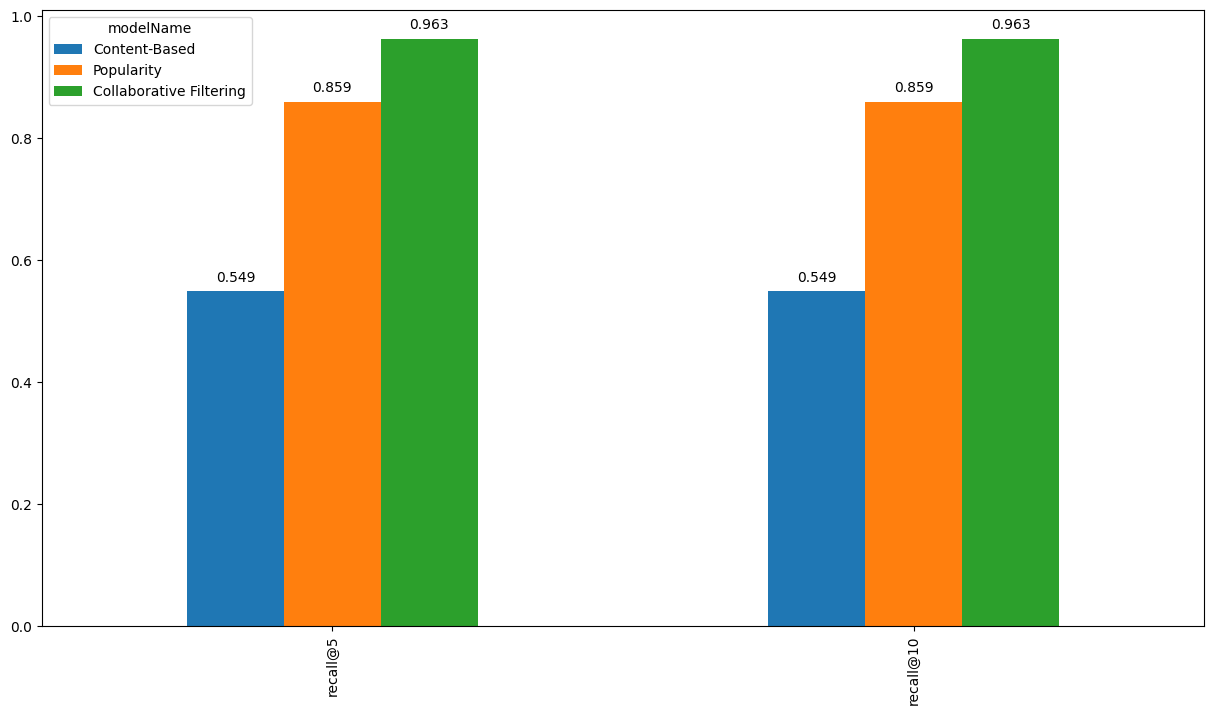

In [315]:
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Reduction de dimensions: PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

pca = PCA(n_components=128, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

In [ ]:
reduced_embeddings.shape

(364047, 128)

In [ ]:
norm_reduced_embeddings = normalize(reduced_embeddings, axis=1)

In [ ]:
np.save(os.path.join(base_path, "norm_reduced_embeddings.npy"), norm_reduced_embeddings)